In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
url = "https://raw.githubusercontent.com/arimitramaiti/datasets/master/Classification/heart.csv"
dataset = pd.read_csv(url, error_bad_lines=False, header=0, index_col=None)
dataset.head()
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


 - __Replicate Feature Selection methods and create train and test sets for each method separately__

In [3]:
sex_dummy = pd.get_dummies(dataset.sex)
sex_dummy.columns = ["Male", "Female"]

cp_dummy = pd.get_dummies(dataset.cp)
cp_dummy.columns = ["cp0", "cp1", "cp2", "cp3"]

fbs_dummy = pd.get_dummies(dataset.fbs)
fbs_dummy.columns = ["fbs0", "fbs1"]

restecg_dummy = pd.get_dummies(dataset.restecg)
restecg_dummy.columns = ["restecg0", "restecg1", "restecg2"]

exang_dummy = pd.get_dummies(dataset.exang)
exang_dummy.columns = ["exang0", "exang1"]

slope_dummy = pd.get_dummies(dataset.slope)
slope_dummy.columns = ["slope0", "slope1", "slope2"]

ca_dummy = pd.get_dummies(dataset.ca)
ca_dummy.columns = ["ca0", "ca1", "ca2", "ca3", "ca4"]

thal_dummy = pd.get_dummies(dataset.thal)
thal_dummy.columns = ["thal0", "thal1", "thal2", "thal3"]

tmp = dataset[["target", "age", "trestbps", "chol", "thalach", "oldpeak"]]

onehot_data = pd.concat([tmp, sex_dummy, cp_dummy, fbs_dummy, restecg_dummy, exang_dummy, slope_dummy, ca_dummy, thal_dummy],
                       axis=1)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif, SelectKBest, SelectPercentile, chi2, f_classif
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

In [5]:
X = onehot_data.drop('target', axis=1)
y = onehot_data['target']
X.shape, y.shape

((303, 30), (303,))

In [6]:
from sklearn.preprocessing import RobustScaler

 - __Perform scaling unlike Decision Tree Classifier which do not require scaling__
 - __Following scaling before train test split and feature extraction process__

In [7]:
vars_to_scale = X[["age", "trestbps", "chol", "thalach", "oldpeak"]]
scaler = RobustScaler()
vars_scaled = scaler.fit_transform(vars_to_scale)

vars_scaled = pd.DataFrame(vars_scaled, columns=["age", "trestbps", "chol", "thalach", "oldpeak"])
vars_original = X[X.columns.difference(vars_to_scale.columns)]

X_new = pd.concat([vars_original, vars_scaled], axis=1)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=0, stratify=y)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(242, 30) (61, 30) (242,) (61,)


In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve
from sklearn.metrics import recall_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Find SVC best parameter for X_train (FE method-RFECV)

In [10]:
del X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

rfe = RFECV(RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1), 
          step=1, 
          cv=StratifiedKFold(10),
          scoring='accuracy', 
          n_jobs=-1).fit(X_train, y_train)

train_copy = X_train
test_copy = X_test

train_copy.drop(train_copy.columns[np.where(rfe.support_ == False)[0]], axis=1, inplace=True)
test_copy.drop(test_copy.columns[np.where(rfe.support_ == False)[0]], axis=1, inplace=True)

X_train_rfe = pd.DataFrame(train_copy)
X_test_rfe = pd.DataFrame(test_copy)
X_train_rfe.shape, X_test_rfe.shape

((242, 26), (61, 26))

In [11]:
def svc_parameter(X_data, y_data):
    C_val = [0.001, 0.01, 0.1, 1, 10]
    gamma_val = [0.001, 0.01, 0.1, 1]
    kernel_val = ["rbf"]
    degree_val = [0, 1, 2, 3, 4, 5, 6]
    param_grid = {'C': C_val, 'gamma': gamma_val, 'kernel': kernel_val, 'degree': degree_val}
    
    gs = GridSearchCV(SVC(), param_grid, cv=StratifiedKFold(10))
    gs.fit(X_data, y_data)
    gs.best_params_
    return gs.best_params_

In [12]:
best_param_values = svc_parameter(X_train_rfe, y_train)

The accuracy score for the model is: 0.754
The recall score for the model is: 0.788
The C value for the model is: 1
The kernel value for the model is: rbf
The degree value for the model is: 0
The gamma value for the model is: 0.001


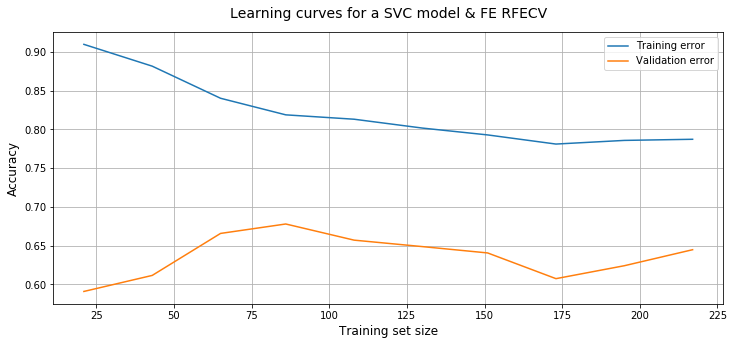

Text(91.68, 0.5, 'Actual')

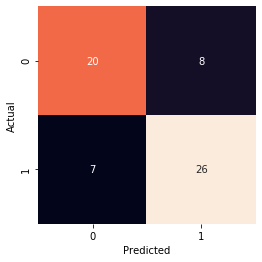

In [13]:
train_size = np.linspace(0.1, 1, 10)
    
model = SVC(C=best_param_values['C'],
            kernel=best_param_values['kernel'],
            degree=best_param_values['degree'],
            gamma=best_param_values['gamma'])
    
train_sizes, train_scores, validation_scores = learning_curve(estimator = model,
                                                                X = X_train_rfe,
                                                                y = y_train,
                                                                train_sizes = train_size,
                                                                cv = StratifiedKFold(10),
                                                                scoring = 'accuracy',
                                                                shuffle = True,
                                                                random_state=1)

train_scores_mean = train_scores.mean(axis = 1)
validation_scores_mean = validation_scores.mean(axis = 1)
    
model.fit(X_train_rfe, y_train)
y_pred = model.predict(X_test_rfe)
acc = round(accuracy_score(y_test, y_pred),3)
rec = round(recall_score(y_test, y_pred),3)
   
print("The accuracy score for the model is: {}".format(acc))
print("The recall score for the model is: {}".format(rec))
print("The C value for the model is: {}".format(best_param_values['C']))
print("The kernel value for the model is: {}".format(best_param_values['kernel']))
print("The degree value for the model is: {}".format(best_param_values['degree']))
print("The gamma value for the model is: {}".format(best_param_values['gamma']))


fig = plt.figure(figsize=(12,5))
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('Accuracy', fontsize = 12)
plt.xlabel('Training set size', fontsize = 12)
plt.title('Learning curves for a SVC model & FE RFECV', fontsize = 14, y = 1.03)
plt.legend()
plt.grid()
plt.show()

met = confusion_matrix(y_test, y_pred)
sns.heatmap(met, square=True, annot=True, fmt="d", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")

In [19]:
from xgboost import XGBClassifier

In [23]:
estimator = XGBClassifier(objective="multi:softmax", num_class=2, random_state=1)

In [32]:
def xgbc_parameter(X_data, y_data):
    learning_rate = np.arange(0.01,1,0.05)
    n_estimators = [100,200]
    max_depth = [10,30,50]
    min_child_weight = [1,3,6]
    param_grid = {'learning_rate': learning_rate,
                  'n_estimators': n_estimators,
                  'max_depth': max_depth,
                  'min_child_weight': min_child_weight}
    
    gs = GridSearchCV(estimator, param_grid, cv=StratifiedKFold(10))
    gs.fit(X_data, y_data)
    gs.best_params_
    return gs.best_params_

In [33]:
best_parameter = xgbc_parameter(X_train_rfe, y_train)

In [35]:
xgbc_model_best = XGBClassifier(objective="multi:softmax", num_class=2, random_state=1,
                               learning_rate=best_parameter['learning_rate'],
                               n_estimators=best_parameter['n_estimators'],
                               max_depth=best_parameter['max_depth'],
                               min_child_weight=best_parameter['min_child_weight'])

The accuracy score for the model is: 0.869
The recall score for the model is: 0.879


Text(91.68, 0.5, 'Actual')

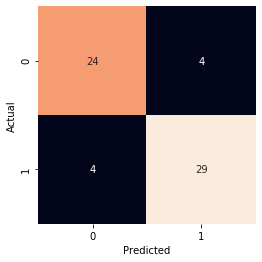

In [36]:
xgbc_model_best.fit(X_train_rfe, y_train)
xgbc_model_best_pred = xgbc_model_best.predict(X_test_rfe)
acc = round(accuracy_score(y_test, xgbc_model_best_pred),3)
rec = round(recall_score(y_test, xgbc_model_best_pred), 3)
print("The accuracy score for the model is: {}".format(acc))
print("The recall score for the model is: {}".format(rec))
met = confusion_matrix(y_test, xgbc_model_best_pred)
sns.heatmap(met, square=True, annot=True, fmt="d", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")

In [37]:
best_parameter['learning_rate']

0.01

In [38]:
best_parameter['n_estimators']

200

In [39]:
best_parameter['max_depth']

10

In [40]:
best_parameter['min_child_weight']

6